In [2]:
import os
import numpy as np
os.getcwd()

'/Users/meganyow/Documents/Interviews/Shopify'

In [3]:
import pandas as pd
cat_tree = pd.read_csv("ecommerce-dataset/category_tree.csv")
events = pd.read_csv("ecommerce-dataset/events.csv")
item_prop1 = pd.read_csv("ecommerce-dataset/item_properties_part1.csv")
item_prop2 = pd.read_csv("ecommerce-dataset/item_properties_part2.csv")

In [4]:
item_prop = pd.concat([item_prop1, item_prop2])

In [6]:
cat_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [50]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [53]:
item_prop['new_value'] = item_prop1.value.apply(lambda x: x[1:].split(" ", 1)[0] if x.startswith('n') else np.nan)


## Events Analysis

In [58]:
events.groupby(['event']).nunique()

,timestamp,visitorid,event,itemid,transactionid
event,,,,,
addtocart,68959,37722,1,23903,0
transaction,20362,11719,1,12025,17672
view,2661325,1404179,1,234838,0


In [59]:
events.groupby(['event']).count()

,timestamp,visitorid,itemid,transactionid
event,,,,
addtocart,69332,69332,69332,0
transaction,22457,22457,22457,22457
view,2664312,2664312,2664312,0


78.7% of transactions are single item so a market basket analysis not suitable

In [61]:
17672 / 22457


0.7869261254842588

In [51]:
visitors=events["visitorid"].unique()
print('Visitor count on actions:',events["visitorid"].shape)
print('Total unique visitors :',visitors.shape)
# unique visitors are almost half the number of total visitors

Visitor count on actions: (2756101,)
Total unique visitors : (1407580,)


Action Plots

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

In [79]:
2661325 / (2661325 + 68959 + 20362) # % of views

0.967527264504411

In [80]:
 68959 / (68959 + 20362) # % of add to carts

0.7720356914947213

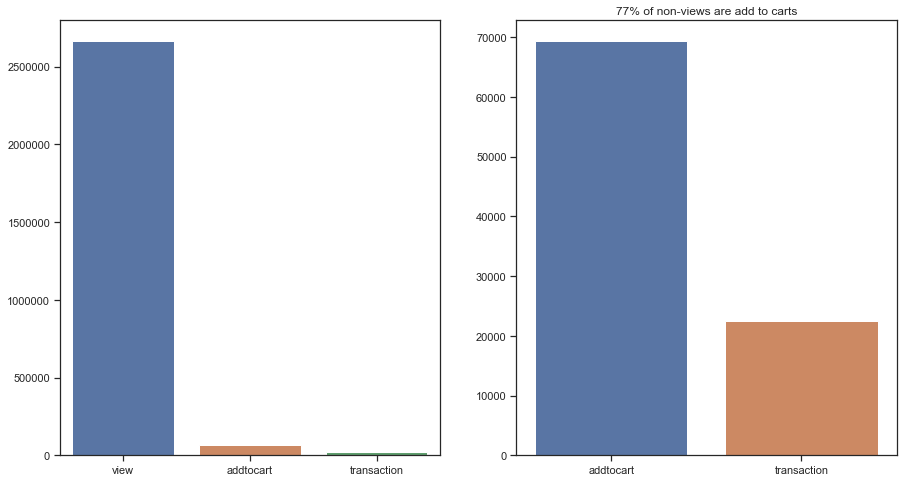

In [81]:
fig, axs = plt.subplots(ncols=2,figsize=(15, 8))
events_count=events["event"].value_counts() # include view
plt.title('96% of events are views')
sns.barplot(events_count.index, events_count.values, ax=axs[0])
events_count=events["event"].value_counts()[1:] # exclude view
plt.title('77% of non-views are add to carts')
g=sns.barplot(events_count.index, events_count.values,ax=axs[1])

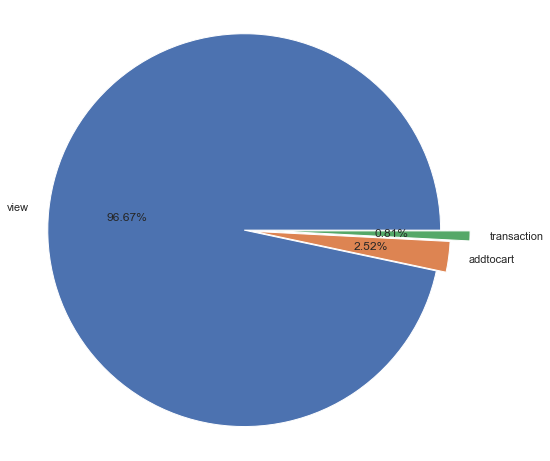

In [82]:
data = events.event.value_counts()
labels = data.index
sizes = data.values
explode = (0, 0.05, 0.15)
fig, ax = plt.subplots(figsize=(8,8))

patches, texts, autotexts = ax.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', shadow=False, startangle=0) 

ax.axis('equal')
plt.show()

In [154]:
grouped = events.groupby(['event','itemid']).count()

In [155]:
grouped = grouped.sort_values(by=['timestamp'],ascending=False)
grouped = grouped.reset_index()

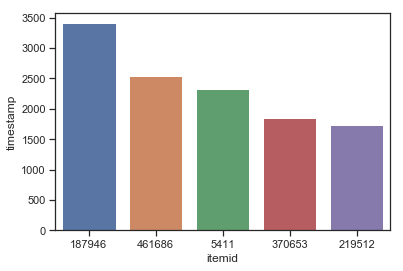

In [162]:
# Views (most viewed item)
y = grouped[grouped['event']=='view'].timestamp[0:5]
x = grouped[grouped['event']=='view'].itemid[0:5]
sns.barplot(x,y,order=x)

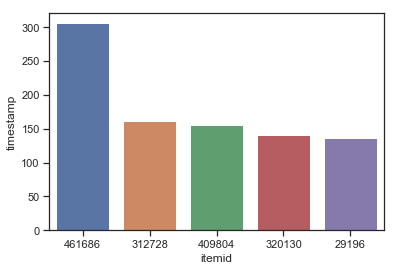

In [163]:
# Addtocart (most popular added to cart items)
y = grouped[grouped['event']=='addtocart'].timestamp[0:5]
x = grouped[grouped['event']=='addtocart'].itemid[0:5]
sns.barplot(x,y,order=x)

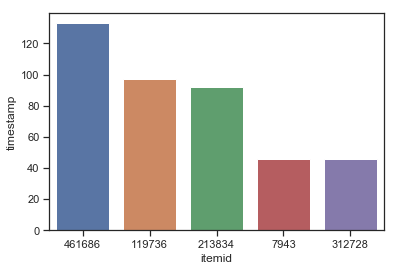

In [164]:
# Transaction (most popular items bought)
y = grouped[grouped['event']=='transaction'].timestamp[0:5]
x = grouped[grouped['event']=='transaction'].itemid[0:5]
sns.barplot(x,y,order=x)

In [175]:
# average number of views for each item is 11, 
# upper 25th percentile item has 9 views or more
grouped[grouped.event == 'view'].timestamp.describe()

count    234838.000000
mean         11.345319
std          35.409345
min           1.000000
25%           1.000000
50%           3.000000
75%           9.000000
max        3410.000000
Name: timestamp, dtype: float64

In [176]:
# average number of views for each item is 2.9, 
# upper 25th percentile item has 3 views or more
grouped[grouped.event == 'addtocart'].timestamp.describe()

count    23903.000000
mean         2.900556
std          5.026141
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        306.000000
Name: timestamp, dtype: float64

In [177]:
# average number of views for each item is 1.8, 
# upper 25th percentile item has 2.0 views or more
grouped[grouped.event == 'transaction'].timestamp.describe()

count    12025.000000
mean         1.867526
std          2.710560
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        133.000000
Name: timestamp, dtype: float64

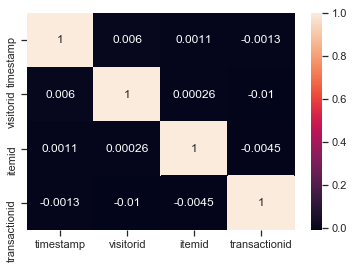

In [178]:
# doesn't tell me anything
corr = events[events.columns].corr()
sns.heatmap(corr,annot = True)

## Log-Likelihood Ratio Recommendation System
https://towardsdatascience.com/how-to-create-a-production-ready-recommender-system-3c932752f8ea

In [26]:
n_users = events['visitorid'].unique().shape[0]
n_items = item_prop['itemid'].max()
print (str(n_users) +" " +  str(n_items))

1407580 466866


In [39]:
import sys
1407580 * 466866 * sys.getsizeof(np.int32()) / (8 * (10 ** 12)) # user-item matrix will be 2.6 TB large, let's not make this

2300.02935498

Because this dataset is so large, let's look at transactions only

In [28]:
trans_events = events[events.event == 'transaction']

In [36]:
visitors = trans_events.visitorid.unique()
items = trans_events.itemid.unique()

print("There are {0} unique visitors and {1} unique items".format(visitors.shape[0], items.shape[0]))

There are 11719 unique visitors and 12025 unique items


In [56]:
trans2 = trans_events.groupby('visitorid').head(50)
trans2['visitors'] = trans2['visitorid'].apply(lambda x : np.argwhere(visitors == x)[0][0])
trans2['items'] = trans2['itemid'].apply(lambda x : np.argwhere(items == x)[0][0])
trans2

/Users/meganyow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/meganyow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,timestamp,visitorid,event,itemid,transactionid,visitors,items
130,1433222276276,599528,transaction,356475,4000.0,0,0
304,1433193500981,121688,transaction,15335,11117.0,1,1
418,1433193915008,552148,transaction,81345,5444.0,2,2
814,1433176736375,102019,transaction,150318,13556.0,3,3
843,1433174518180,189384,transaction,310791,7244.0,4,4
1214,1433184261340,350566,transaction,54058,8796.0,5,5
1215,1433184261371,350566,transaction,284871,8796.0,5,6
1234,1433182772710,404403,transaction,150100,5216.0,6,7
1350,1433164275232,505565,transaction,243566,11713.0,7,8
1512,1433180403455,945184,transaction,245400,2415.0,8,9


In [60]:
11719 * 12025 * sys.getsizeof(np.int32()) / (8 * (10 ** 6)) 
# user-item matrix will be 500MB large, sparse matrix to the rescue

493.2234125

In [64]:
from scipy.sparse import csr_matrix, lil_matrix

In [65]:
occurences = lil_matrix((visitors.shape[0], items.shape[0]), dtype='int8')

def set_occurences(visitor, item):
    occurences[visitor, item] += 1
    
trans2.apply(lambda row: set_occurences(row['visitors'], row['items']), axis=1)
occurences

<11719x12025 sparse matrix of type '<class 'numpy.int8'>'
	with 18905 stored elements in LInked List format>

From those 140 million cells in the matrix, only 18,905 are filled with non-zero.  
So basically you only need to store those 18,905 value to the memory. A 99.99% improved efficiency.  
The downside of the sparse matrix is, it is computationally higher when trying to retrieve the data in real-time. So, you should not finish at this step.  

Now let's create a co-occurence matrix i.e. an item-item matrix where each element means how many times both items bought togehter by a user.  
To create one we need to do the dot product the transpose of the occursence matrix with itself.  

In [66]:
cooc = occurences.transpose().dot(occurences)
cooc.setdiag(0)

/Users/meganyow/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Use Log-Likelihood Ratio to penalize the score of co-occurence matrix to make predictions generalizable  
remove effects on purchasing behaviour caused by flash sale  
http://tdunning.blogspot.com/2008/03/surprise-and-coincidence.html

In [68]:
def xLogX(x):
    return x * np.log(x) if x != 0 else 0.0

def entropy(x1, x2=0, x3=0, x4=0):
    return xLogX(x1 + x2 + x3 + x4) - xLogX(x1) - xLogX(x2) - xLogX(x3) - xLogX(x4)

def LLR(k11, k12, k21, k22):
    """
    calculate likelihood of two events, A and B appear together

    k11, number of when both events appeared together
    k12, number of B appear without A
    k21, number of A appear without B
    k22, number of other things appeared without both of them
    """
    rowEntropy = entropy(k11 + k12, k21 + k22)
    columnEntropy = entropy(k11 + k21, k12 + k22)
    matrixEntropy = entropy(k11, k12, k21, k22)
    if rowEntropy + columnEntropy < matrixEntropy:
        return 0.0
    return 2.0 * (rowEntropy + columnEntropy - matrixEntropy)

def rootLLR(k11, k12, k21, k22):
    llr = LLR(k11, k12, k21, k22)
    sqrt = np.sqrt(llr)
    if k11 * 1.0 / (k11 + k12) < k21 * 1.0 / (k21 + k22):
        sqrt = -sqrt
    return sqrt

In [70]:
row_sum = np.sum(cooc, axis=0).A.flatten()
column_sum = np.sum(cooc, axis=1).A.flatten()
total = np.sum(row_sum, axis=0)
pp_score = csr_matrix((cooc.shape[0], cooc.shape[1]), dtype='double')
cx = cooc.tocoo()

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v != 0:
        k11 = v
        k12 = row_sum[i] - k11
        k21 = column_sum[j] - k11
        k22 = total - k11 - k12 - k21
        pp_score[i,j] = rootLLR(k11, k12, k21, k22)

/Users/meganyow/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [71]:
result = np.flip(np.sort(pp_score.A, axis=1), axis=1)
result_indices = np.flip(np.argsort(pp_score.A, axis=1), axis=1)

In [72]:
result[8456]

array([15.33511076, 14.60017668,  3.62091635, ...,  0.        ,
        0.        ,  0.        ])

In [73]:
result_indices[8456]

array([8682,  380, 8501, ..., 8010, 8009,    0])

You can safely answer that with a high number of LLR score, item 8682 and 380 can be an indicator for item 8456. While item 8501 since the score is not that big, might not be an indicator for item 8456.
It means that, if someone bought 8682 and 380, you can recommend him 8456.

In [74]:
minLLR = 5
indicators = result[:, :50]
indicators[indicators < minLLR] = 0.0
indicators_indices = result_indices[:, :50]
max_indicator_indices = (indicators==0).argmax(axis=1)
max = max_indicator_indices.max()
indicators = indicators[:, :max+1]
indicators_indices = indicators_indices[:, :max+1]

## Productionalize Model

Using elasticsearch using bulk API that can send multiple documents at once

In [75]:
import requests
import json

In [77]:
def bulk_update(url, items):
    actions = []
    for i in range(indicators.shape[0]):
        length = indicators[i].nonzero()[0].shape[0]
        real_indicators = items[indicators_indices[i, :length]].astype("int").tolist()
        id = items[i]

        action = { "index" : { "_index" : "items2", "_id" : str(id) } }

        data = {
            "id": int(id),
            "indicators": real_indicators
        }

        actions.append(json.dumps(action))
        actions.append(json.dumps(data))

        if len(actions) == 200:
            actions_string = "\n".join(actions) + "\n"
            actions = []

            #url = "http://127.0.0.1:9200/_bulk/"
            headers = {
                "Content-Type" : "application/x-ndjson"
            }
            requests.post(url, headers=headers, data=actions_string)
    if len(actions) > 0:
        actions_string = "\n".join(actions) + "\n"
        actions = []
        #url = "http://127.0.0.1:9200/_bulk/"
        headers = {
            "Content-Type" : "application/x-ndjson"
        }
        requests.post(url, headers=headers, data=actions_string)